# Практическая работа 3: Анализ данных авиакомпаний

## Задание 16
**Цель:** рассчитать освоенный бюджет для каждого партнера:
- **Файл 1 (CSV):** Партнеры (partner_id, name)
- **Файл 2 (Excel):** Проекты (partner_id, project_id, budget)
- **Файл 3 (JSON):** Выполнение: (project_id, completion_percent)

## Библиотеки и подключения


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✓ Библиотеки загружены")


✓ Библиотеки загружены


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Загрузка данных из различных источников


In [5]:
# Загрузка данных об авиакомпаниях (CSV)
df_partners = pd.read_csv('/content/drive/MyDrive/2 курс 1 семестр/пр.ср-ва сбора, консолидации и аналитики данных/PW_03/partners.csv') #('data/partners.csv')
print("Данные о партнерах (CSV):")
print(f"Форма данных: {df_partners.shape}")
print(df_partners.head())
print("\n" + "="*50 + "\n")


Данные о партнерах (CSV):
Форма данных: (10, 2)
  partner_id       name
0       P001  PARTNER01
1       P002  PARTNER02
2       P003  PARTNER03
3       P004  PARTNER04
4       P005  PARTNER05




In [6]:
# Загрузка данных о рейсах (Excel)
df_projects = pd.read_excel('/content/drive/MyDrive/2 курс 1 семестр/пр.ср-ва сбора, консолидации и аналитики данных/PW_03/projects.xlsx') #('data/projects.xlsx')
print("Данные о проектах (Excel):")
print(f"Форма данных: {df_projects.shape}")
print(df_projects.head())
print("\n" + "="*50 + "\n")


Данные о проектах (Excel):
Форма данных: (5000, 4)
  project_id partner_id  project_type  budget
0    pr00001       P002           mvp    7010
1    pr00002       P004  optimization   30436
2    pr00003       P009           mvp    9155
3    pr00004       P001           mvp    5850
4    pr00005       P009           mvp   13262




In [7]:
# Загрузка данных о билетах (JSON)

# 'data/projects_completion_percent.json'
with open('/content/drive/MyDrive/2 курс 1 семестр/пр.ср-ва сбора, консолидации и аналитики данных/PW_03/projects_completion_percent.json', 'r', encoding='utf-8') as f:
    completion_data = json.load(f)

df_completion = pd.DataFrame(completion_data)
print("Данные о билетах (JSON):")
print(f"Форма данных: {df_completion.shape}")
print(df_completion.head())
print("\n" + "="*50 + "\n")


Данные о билетах (JSON):
Форма данных: (5000, 2)
  project_id  completion_percent
0    pr00001            0.853659
1    pr00002            0.372658
2    pr00003            0.645745
3    pr00004            0.094885
4    pr00005            0.644815




## 2. Консолидация данных и расчет выручки


In [33]:
# Объединение всех данных
# Шаг 1: Объединение партнеров с проектами
df_partners_projects = pd.merge(df_partners, df_projects, on='partner_id', how='inner')

# Шаг 2: Объединение с данными авиакомпаний
df_consolidated = pd.merge(df_partners_projects, df_completion, on='project_id', how='inner')

# Освоенная сумма бюджета
df_consolidated['budget_executed'] = df_consolidated['budget'] * df_consolidated['completion_percent']

print("Консолидированные данные:")
print(f"Форма данных: {df_consolidated.shape}")
print(df_consolidated[['name', 'project_id', 'budget', 'completion_percent', 'budget_executed']].head())

# Расчет среднего % выполнения работ и суммы освоенного бюджета для каждой партнерской компании
partners_budget_execution = df_consolidated.groupby(['partner_id', 'name']).agg({
    'budget': 'sum',
    'budget_executed': 'sum',
    'project_id': 'nunique'
}).round(2)

partners_budget_execution.columns = ['total_budget', 'total_budget_executed', 'projects_count']
partners_budget_execution['avg_completion_rate'] = (partners_budget_execution['total_budget_executed']/partners_budget_execution['total_budget']).round(2)
partners_budget_execution = partners_budget_execution.sort_values('avg_completion_rate', ascending=False)

print("\n" + "="*60)
print("ОСВОЕНИЕ БЮДЖЕТА КОМПАНИЯМИ-ПАРТНЕРАМИ")
print("="*60)
print(partners_budget_execution)


Консолидированные данные:
Форма данных: (5000, 7)
        name project_id  budget  completion_percent  budget_executed
0  PARTNER01    pr00004    5850            0.094885       555.077693
1  PARTNER01    pr00015   37280            0.050099      1867.678748
2  PARTNER01    pr00022   29807            0.056707      1690.260943
3  PARTNER01    pr00030    4259            0.901600      3839.912734
4  PARTNER01    pr00040   10255            0.321152      3293.418499

ОСВОЕНИЕ БЮДЖЕТА КОМПАНИЯМИ-ПАРТНЕРАМИ
                      total_budget  total_budget_executed  projects_count  \
partner_id name                                                             
P010       PARTNER10      55987312            30368097.98             497   
P001       PARTNER01      49937389            26480662.12             464   
P005       PARTNER05      58373145            29786729.98             520   
P008       PARTNER08      58468781            29103672.63             501   
P007       PARTNER07      59156091

## 3. Визуализация результатов


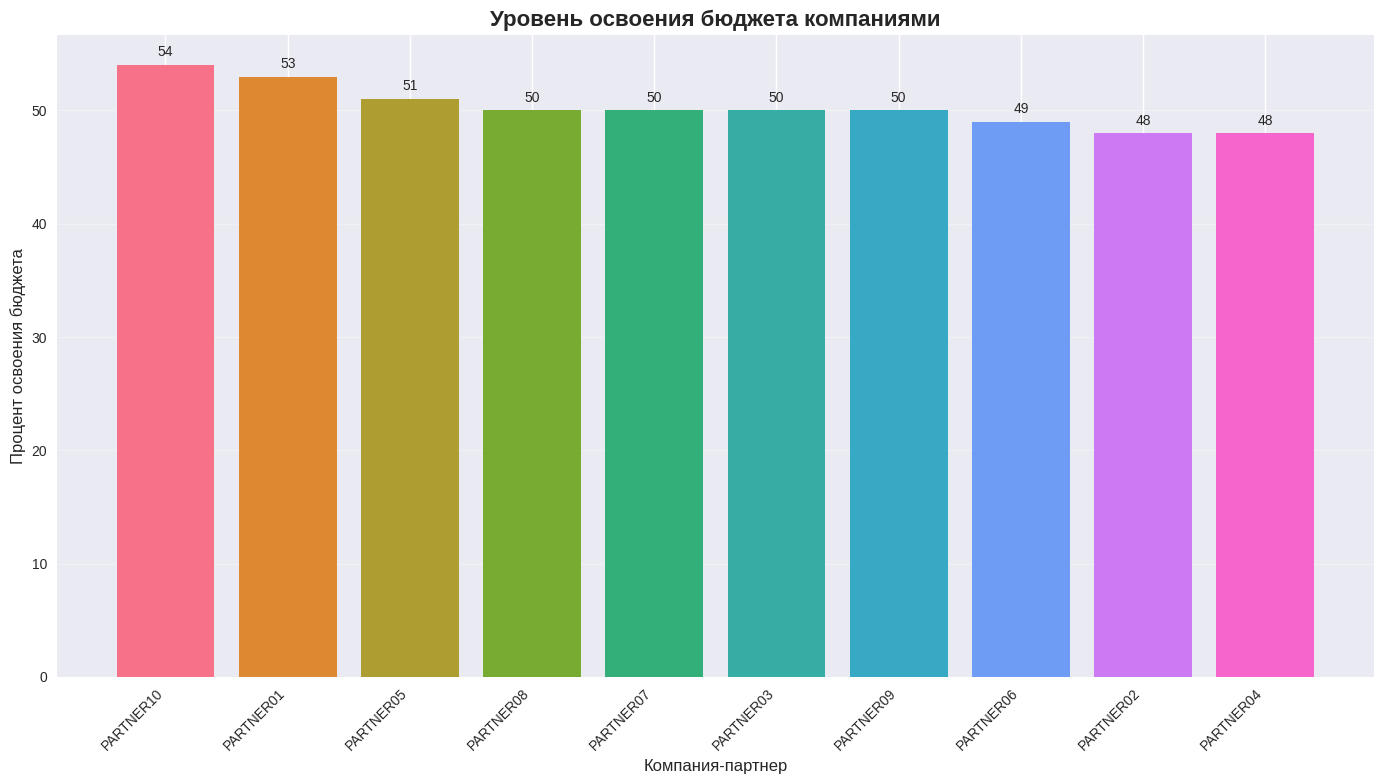

In [78]:
# График 1: Общая выручка авиакомпаний

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(partners_budget_execution)), partners_budget_execution['avg_completion_rate']*100,
               color=sns.color_palette("husl", len(partners_budget_execution)))
plt.title('Уровень освоения бюджета компаниями', fontsize=16, fontweight='bold')
plt.xlabel('Компания-партнер', fontsize=12)
plt.ylabel('Процент освоения бюджета', fontsize=12)
plt.xticks(range(len(partners_budget_execution)), partners_budget_execution.index.get_level_values('name'),
           rotation=45, ha='right')

# Добавление значений на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


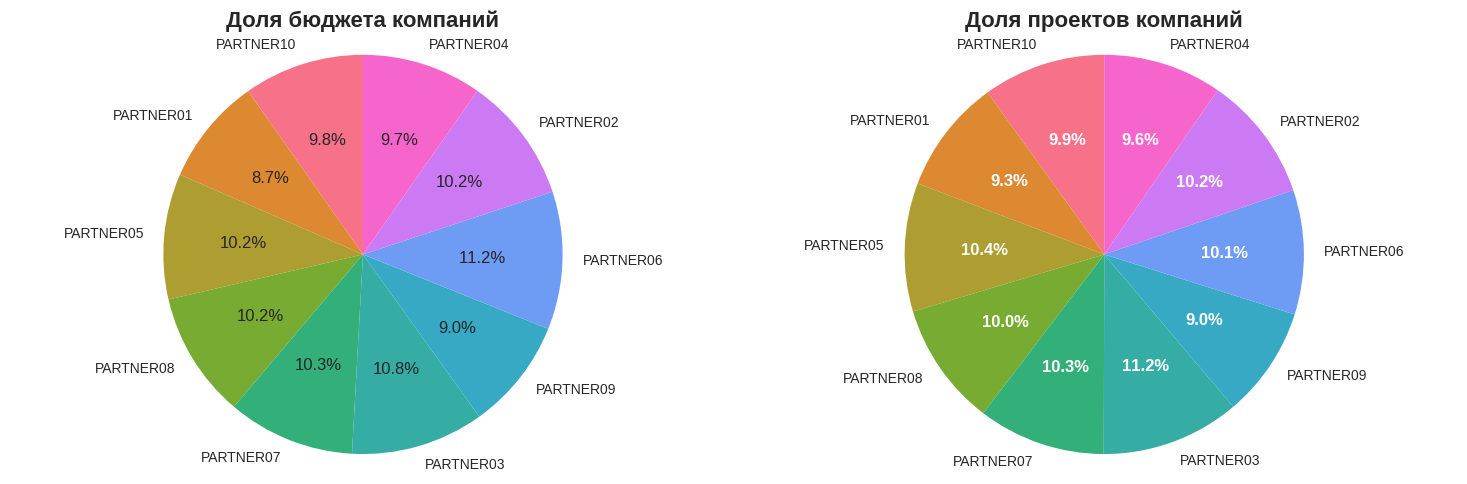

In [41]:
# График 2: Круговая диаграмма доли бюджета в общей сумме бюджета топ-10
plt.figure(figsize = (15,5))
colors = sns.color_palette("husl", len(partners_budget_execution))
plt.subplot(1,2,1)
wedges, texts, autotexts = plt.pie(partners_budget_execution['total_budget'],
                                   labels=partners_budget_execution.index.get_level_values('name'),
                                   autopct='%1.1f%%', colors=colors, startangle=90)
plt.axis('equal')
plt.title('Доля бюджета компаний', fontsize=16, fontweight='bold')
plt.subplot(1,2,2)
wedges, texts, autotexts = plt.pie(partners_budget_execution['projects_count'],
                                   labels=partners_budget_execution.index.get_level_values('name'),
                                   autopct='%1.1f%%', colors=colors, startangle=90)
plt.axis('equal')
plt.title('Доля проектов компаний', fontsize=16, fontweight='bold')

# Улучшение читаемости
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

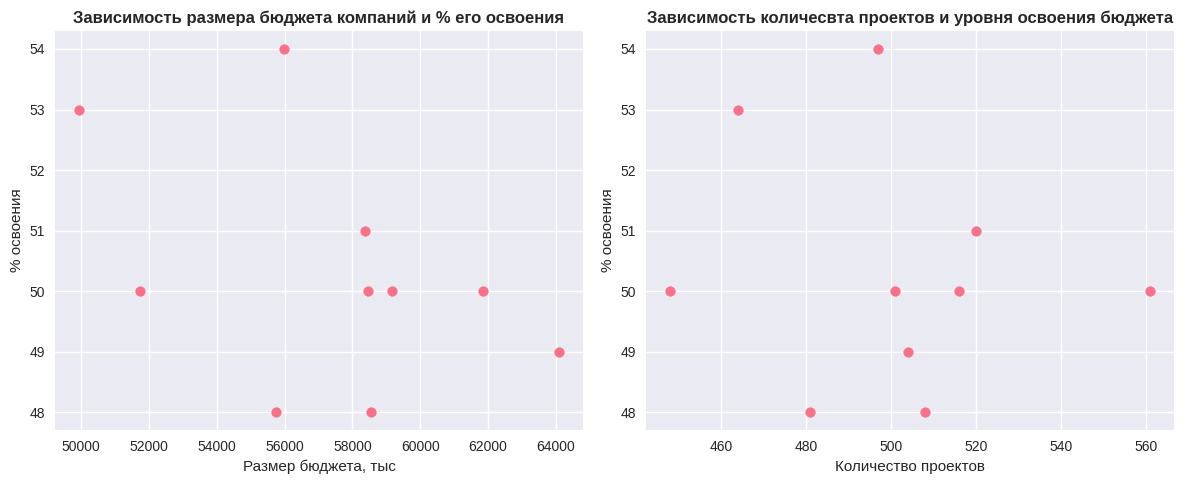

In [45]:
# График 3: Зависимость размера бюджета компаний и % его освоения
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(x = partners_budget_execution['total_budget']/1000, y = partners_budget_execution['avg_completion_rate']*100)

plt.title('Зависимость размера бюджета компаний и % его освоения', fontsize=12, fontweight='bold')
plt.xlabel("Размер бюджета, тыс")
plt.ylabel ("% освоения")

plt.subplot(1,2,2)
plt.scatter(x = partners_budget_execution['projects_count'], y = partners_budget_execution['avg_completion_rate']*100)
plt.title("Зависимость количесвта проектов и уровня освоения бюджета", fontsize = 12, fontweight = 'bold')
plt.xlabel("Количество проектов")
plt.ylabel("% освоения")

# Улучшение читаемости
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

> - связь между размером бюджета и % его освоения не выявлена.
> - также нет связи между количеством проектов у компании и уровнем освноения бюджета - проекты распределены между компаниями практичски поровну

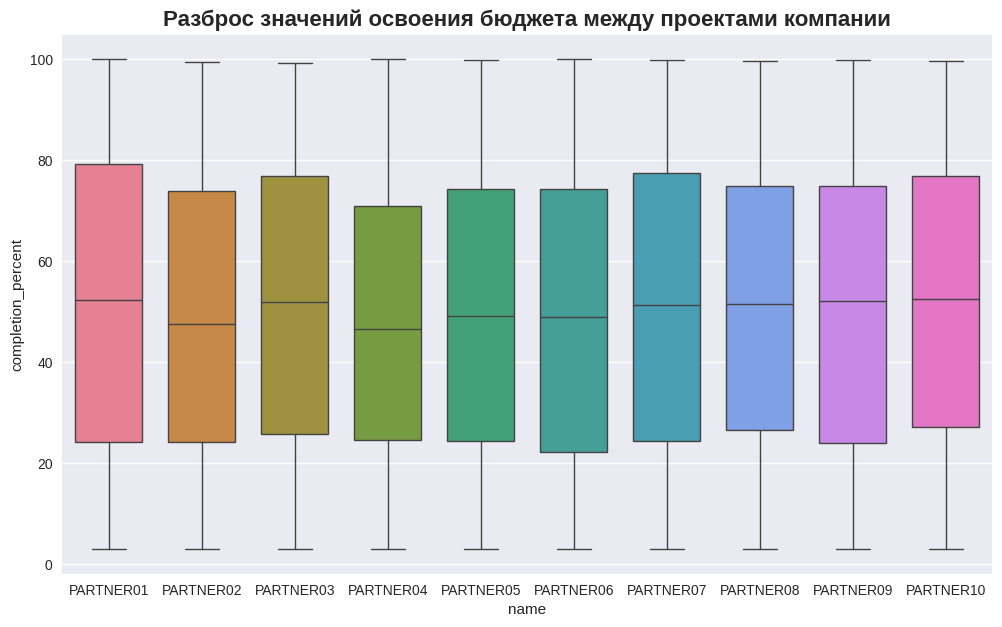

In [58]:
plt.figure(figsize = (12,7))
sns.boxplot(data = df_consolidated, x = 'name', y = df_consolidated['completion_percent']*100, hue = 'name', gap=.1)  # ,medianprops={"color": "darkblue", "linewidth": 2})
plt.title("Разброс значений освоения бюджета между проектами компании", fontsize = 16, fontweight = 'bold')
plt.show()

In [74]:
# График 5: Интерактивная визуализация с Plotly
fig = go.Figure()

# Добавляем столбцы выручки
fig.add_trace(go.Bar(
    x=partners_budget_execution.index.get_level_values('name'),
    y=partners_budget_execution['avg_completion_rate']*100,
    name='Уровень освоения',
    marker_color='lightblue',
    text=[f'{x:,.0f} %' for x in partners_budget_execution['avg_completion_rate']*100],
    textposition='auto'
))

fig.update_layout(
    title='Интерактивная диаграмма уровня освоения бюджета',
    xaxis_title='Компания-партнер',
    yaxis_title='Освоение бюджета, %',
    showlegend=False,
    height=600
)

fig.show()


In [77]:
# График 5: Интерактивная визуализация с Plotly
fig = go.Figure()

# Добавляем столбцы выручки
fig.add_trace(go.Box(
    x=df_consolidated['name']
    , y=df_consolidated['completion_percent']*100
    , name='Уровень освоения'
    , marker_color='lightblue'
    #, orientation="h"
    #, text=[f'{x:,.0f} %' for x in partners_budget_execution['avg_completion_rate']]
    #, textposition='auto'
))

fig.update_layout(
    title='Интерактивная диаграмма разброса уровня освоения бюджета',
    xaxis_title='Компания-партнер',
    yaxis_title='Освоение бюджета, %',
    showlegend=False,
    height=600
)

fig.show()

## 4. Выводы и сохранение результатов


In [89]:
# Формирование выводов и сохранение результатов
print("ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА")
print("=" * 50)

top_partner = partners_budget_execution.index[0][1]
top_avg_completion_rate = partners_budget_execution.iloc[0]['avg_completion_rate']*100
total_budget = partners_budget_execution['total_budget'].sum()
total_budget_executed = partners_budget_execution['total_budget_executed'].sum()
total_avg_completion_rate = (total_budget_executed  / total_budget) * 100
projects_67perc_completed_and_more = df_consolidated[df_consolidated['completion_percent']>=0.67]['project_id'].nunique()
total_project = df_consolidated['project_id'].nunique()
share_projects_67perc_completed_and_more = (projects_67perc_completed_and_more/total_project)*100


print(f"1. Лидер по освоению бюджета: {top_partner}")
print(f"   - Самый высокий % освоения: {top_avg_completion_rate:,.1f} %")
print(f"   - Всего выделено бюджета: {total_budget:.1f} руб.")
print(f"   - Всего проектов в работе: {total_project:.1f}")

print(f"\n2. Всего освоено бюджета: {total_budget_executed:,.0f} руб.")
print(f"3. Общий % освоения бюджета: {total_avg_completion_rate:,.1f} %")
print(f"4. Доля проектов, завершенных более, чем на 2/3: {share_projects_67perc_completed_and_more} %")


# Топ-3 авиакомпании
print("\n5. ТОП-3 партнера по ср.освоению бюджета:")
for i, (idx, row) in enumerate(partners_budget_execution.head(3).iterrows(), 1):
    partner_name = idx[1]
    completion = row['avg_completion_rate']*100
    projects = row['projects_count']
    budget = row['total_budget']
    print(f"   {i}. {partner_name}: {completion:,.0f} % (бюджет {budget} руб.,{projects} проектов)")

# Сохранение результатов
df_consolidated.to_csv('consolidated_partners_budget_execution_data.csv', index=False) # 'data/...'
partners_budget_execution.to_csv('partners_budget_execution_summary.csv') # 'data/...'

print("\n" + "=" * 50)
print("✓ Результаты сохранены в папке 'data/'")
print("✓ Анализ завершен успешно!")


ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА
1. Лидер по освоению бюджета: PARTNER10
   - Самый высокий % освоения: 54.0 %
   - Всего выделено бюджета: 573890834.0 руб.
   - Всего проектов в работе: 5000.0

2. Всего освоено бюджета: 288,226,809 руб.
3. Общий % освоения бюджета: 50.2 %
4. Доля проектов, завершенных более, чем на 2/3: 33.7 %

5. ТОП-3 партнера по ср.освоению бюджета:
   1. PARTNER10: 54 % (бюджет 55987312.0 руб.,497.0 проектов)
   2. PARTNER01: 53 % (бюджет 49937389.0 руб.,464.0 проектов)
   3. PARTNER05: 51 % (бюджет 58373145.0 руб.,520.0 проектов)

✓ Результаты сохранены в папке 'data/'
✓ Анализ завершен успешно!
